In [2]:
#basic imports and ipython setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

sys.path.append('../MCEq')
os.chdir('..')

#import solver related modules
#import primary model choices
import crflux.models as pm

from MCEq.core import MCEqRun
#from MCEq import config
import MCEq.config as config
from MCEq.particlemanager import MCEqParticle

In [3]:
#This cell is for MCEq 3.0 or older, they changed the config module

#config.compact_mode = False
#config.low_energy_extension['enable'] = True
#config.store_solution = True

In [5]:
MIN_ZENITH_DEG = 0     # lower edge of the zenith bin (degrees)
MAX_ZENITH_DEG = 78.5    # upper edge of the zenith bin (degrees):  cos(78.5deg) = 0.2
run = 2  #Set to an integer to save to a file named "angleAvg_{run}.pkl.gz"

In [4]:
config.mceq_db_fname = "mceq_db_fine_v150.h5"
config.decay_db_name = "full_decays" #or "pythia_decays_K3b_202206"
config.muon_helicity_dependence = True

In [4]:
mceq_run = MCEqRun(
interaction_medium = 'air',
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.HillasGaisser2012, 'H3a'),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=MAX_ZENITH_DEG,
#expand the rest of the options from mceq_config.py
#**config
)
mceq_run.set_density_model(('MSIS00_IC', ('SouthPole', "October")))
mag = 3
pman = mceq_run.pman

MCEqRun::set_interaction_model(): SIBYLL23C
HDF5Backend::decay_db(): Warning: Does this decay dataset 'full_decays' include polarization?
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'October')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 78.50


In [5]:
# Re-apply the appropriate databases, hopefully initializes the tables for our added particles
pman.set_cross_sections_db(mceq_run._int_cs)
pman.set_decay_channels(mceq_run._decays)
pman.set_interaction_model(mceq_run._int_cs, mceq_run._interactions)

In [ ]:
import numpy as np


def average_over_angles(
    mceq_run,
    mag,
    min_angle_deg,
    max_angle_deg,
    save_to_file=0,
    bins=5,
):
    """
    Run MCEq for "bins" number of equally-spaced cos θ bins, then return angle-averaged spectra.

    The routine performs **two** passes over the angle grid:

    1.  First loop solves only for the conventional, prompt, total,
        and pion-decay μ spectra. The prompt component gets messed up
        at higher energies for reasons unknown if tracking particles
        are added beforehand.

    2.  Second loop registers the parent→lepton tracking just once,
        rebuilds the matrices, and solves again for every parent group
        specified in ``parent_groups``.

    Parameters
    ----------
    mceq_run : mceq.core.MCEqRun
        A fully configured MCEqRun instance.
    mag : int | slice | ndarray
        Energy-bin selector you normally pass to ``get_solution``.
    min_angle_deg, max_angle_deg : float
        Angular bounds (zenith, in degrees). 0° = downgoing.
    bins : int, optional
        Number of angular sub-bins. Default is 5.

    Returns
    -------
    primary_fluxes : dict
        Keys ``mu_conv`` … ``nutau_total`` and ``pi_mu`` – each is the
        **angle-averaged** spectrum.
    parent_fluxes : dict
        ``parent_fluxes[flavour][parent_label]`` – angle-averaged spectra
        for every tracked parent.  Flavours are ``'mu'``, ``'numu'``,
        ``'nue'`` and ``'nutau'``.
    zenith_midpoints : ndarray
        Mid-point zenith angles (°) actually simulated.
    """

    # 1. Build the zenith grid
    cos_edges = np.linspace(
        np.cos(np.deg2rad(max_angle_deg)),
        np.cos(np.deg2rad(min_angle_deg)),
        bins + 1,
    )
    zenith_edges_deg = np.degrees(np.arccos(cos_edges))
    zenith_midpoints = 0.5 * (zenith_edges_deg[:-1] + zenith_edges_deg[1:])

    mceq_run.set_density_model(("MSIS00_IC", ("SouthPole", "April")))

    # Containers for the first pass
    mu_conv_list, numu_conv_list, nue_conv_list = [], [], []
    mu_prompt_list, numu_prompt_list, nue_prompt_list = [], [], []
    mu_total_list, numu_total_list, nue_total_list, nutau_total_list = [], [], [], []
    pi_mu_list = []

    # 2. FIRST PASS – no parent-tracking
    for zenith in zenith_midpoints:
        mceq_run.set_theta_deg(float(zenith))
        mceq_run.solve()

        # --- Conventional component
        mu_conv_list.append(
            mceq_run.get_solution("conv_mu+", mag)
            + mceq_run.get_solution("conv_mu-", mag)
        )
        numu_conv_list.append(
            mceq_run.get_solution("conv_numu", mag)
            + mceq_run.get_solution("conv_antinumu", mag)
        )
        nue_conv_list.append(
            mceq_run.get_solution("conv_nue", mag)
            + mceq_run.get_solution("conv_antinue", mag)
        )

        # --- Prompt component
        mu_prompt_list.append(
            mceq_run.get_solution("pr_mu+", mag)
            + mceq_run.get_solution("pr_mu-", mag)
        )
        numu_prompt_list.append(
            mceq_run.get_solution("pr_numu", mag)
            + mceq_run.get_solution("pr_antinumu", mag)
        )
        nue_prompt_list.append(
            mceq_run.get_solution("pr_nue", mag)
            + mceq_run.get_solution("pr_antinue", mag)
        )

        # --- Total component
        mu_total_list.append(
            mceq_run.get_solution("total_mu+", mag)
            + mceq_run.get_solution("total_mu-", mag)
        )
        numu_total_list.append(
            mceq_run.get_solution("total_numu", mag)
            + mceq_run.get_solution("total_antinumu", mag)
        )
        nue_total_list.append(
            mceq_run.get_solution("total_nue", mag)
            + mceq_run.get_solution("total_antinue", mag)
        )
        nutau_total_list.append(
            mceq_run.get_solution("total_nutau", mag)
            + mceq_run.get_solution("total_antinutau", mag)
        )

        # Pion->muon decay, add this manually bc MCEq already
        #  calculates this flux without added tracking
        pi_mu_list.append(
            mceq_run.get_solution("pi_mu+_l", mag)
            + mceq_run.get_solution("pi_mu+_r", mag)
            + mceq_run.get_solution("pi_mu-_l", mag)
            + mceq_run.get_solution("pi_mu-_r", mag)
        )

    # Average the primary spectra
    primary_fluxes = {
        "mu_conv":   np.mean(mu_conv_list,   axis=0),
        "numu_conv": np.mean(numu_conv_list, axis=0),
        "nue_conv":  np.mean(nue_conv_list,  axis=0),
        "mu_prompt":   np.mean(mu_prompt_list,   axis=0),
        "numu_prompt": np.mean(numu_prompt_list, axis=0),
        "nue_prompt":  np.mean(nue_prompt_list,  axis=0),
        "mu_total":   np.mean(mu_total_list,   axis=0),
        "numu_total": np.mean(numu_total_list, axis=0),
        "nue_total":  np.mean(nue_total_list,  axis=0),
        "nutau_total": np.mean(nutau_total_list, axis=0),
        "pi_mu": np.mean(pi_mu_list, axis=0),
    }


    # 3. Register the parent→lepton tracking ONCE
    _register_parents_for_tracking(mceq_run)

    # Containers for the second pass
    parent_groups = (
        "Dpm", "D0", "Ds", "Kpm", "K0s", "K0L",
        "Pion", "Muon"
    )
    parent_fluxes = {
        flavour: {parent: [] for parent in parent_groups}
        for flavour in ("mu", "numu", "nue", "nutau")
    }


    # 4. SECOND PASS – with parent-tracking
    for zenith in zenith_midpoints:
        mceq_run.set_theta_deg(float(zenith))
        mceq_run.solve()

        for parent in parent_groups:
            parent_fluxes["mu"][parent].append(
                mceq_run.get_solution(f"{parent}_mu-", mag)
                + mceq_run.get_solution(f"{parent}_mu+", mag)
            )
            parent_fluxes["numu"][parent].append(
                mceq_run.get_solution(f"{parent}_numu", mag)
                + mceq_run.get_solution(f"{parent}_antinumu", mag)
            )
            parent_fluxes["nue"][parent].append(
                mceq_run.get_solution(f"{parent}_nue", mag)
                + mceq_run.get_solution(f"{parent}_antinue", mag)
            )
            parent_fluxes["nutau"][parent].append(
                mceq_run.get_solution(f"{parent}_nutau", mag)
                + mceq_run.get_solution(f"{parent}_antinutau", mag)
            )

        # Add the special π± → μ± helicity tracks to the Pion entry
        parent_fluxes["mu"]["Pion"][-1] += (
            mceq_run.get_solution("pi_mu+_l", mag)
            + mceq_run.get_solution("pi_mu+_r", mag)
            + mceq_run.get_solution("pi_mu-_l", mag)
            + mceq_run.get_solution("pi_mu-_r", mag)
        )

    # Average the parent-tracked spectra
    for flavour in parent_fluxes:
        for parent in parent_fluxes[flavour]:
            parent_fluxes[flavour][parent] = np.mean(
                parent_fluxes[flavour][parent], axis=0
            )

    return primary_fluxes, parent_fluxes, zenith_midpoints

    # ----------------------------------------------------------------------
    # Helper – register parents once and rebuild matrices
    def _register_parents_for_tracking(mceq_run):
        """
        Declare all parent→lepton tracking only on the first call.
        """
        if getattr(mceq_run.pman, "_parents_registered", False):
            return

        parent_groups = [
            ([(411, 0), (-411, 0)], "Dpm"),
            ([(421, 0), (-421, 0)], "D0"),
            ([(431, 0), (-431, 0)], "Ds"),
            ([(321, 0), (-321, 0)], "Kpm"),
            ([(310, 0)], "K0s"),
            ([(130, 0)], "K0L"),
            ([(211, 0), (-211, 0)], "Pion"),
            ([(4122, 0), (-4122, 0)], "LambdaC"),
            ([(111, 0), (221, 0), (331, 0)], "Unflavoured"),
            ([(13, 0), (-13, 0), (13, 1), 
            (-13, 1), (13, -1), (-13, -1),],"Muon"),
        ]

        for pdg_list, label in parent_groups:
            mceq_run.pman.track_leptons_from(
                parent_pdg_list=pdg_list,
                prefix=f"{label}_",
                exclude_em=True,
                use_helicities=False,
            )

        mceq_run._resize_vectors_and_restore()
        mceq_run.regenerate_matrices()
        mceq_run.pman._parents_registered = True


In [5]:
primary, parents, zeniths = average_over_angles(
    mceq_run,3,
    MIN_ZENITH_DEG,MAX_ZENITH_DEG,
    save_to_file=run,bins=1)

NameError: name 'mceq_run' is not defined

In [ ]:
#Manually save Results:
def save_angle_average(outfile: str, primary, parents, zeniths):
    """
    Compress-serialise (primary, parents, zeniths) → outfile (.pkl.gz).
    """
    import gzip, pickle, pathlib

    outfile = pathlib.Path(outfile).with_suffix(".pkl.gz")
    outfile.parent.mkdir(parents=True, exist_ok=True)

    with gzip.open(outfile, "wb") as fh:
        pickle.dump(
            {"primary": primary,
            "parents": parents,
            "zeniths": zeniths},
            fh,
            protocol=pickle.HIGHEST_PROTOCOL,
        )
    print(f"[MCEq] Results written → {outfile}")

save_angle_average(
    outfile = f"angleAvg_{run}",
    primary = primary,
    parents = parents,
    zeniths = zeniths,
)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# labels for source names
label_map = {
    'Dpm': r'$D^\pm$',                                  # D+ and D-
    'D0': r'$D^0$',                                     # D0 and anti-D0
    'Ds': r'$D_s$',                                     # Ds+ and Ds-
    'Kpm': r'$K^\pm$',                                  # K+ and K-
    'K0s': r'$K^0_S$',                                  # K0 short
    'K0L': r'$K^0_L$',                                  # K0 long
    'Pion': r'$\pi^\pm$',                               # pi+ and pi-
    'LambdaC': r'$\Lambda_c$',                          # Lambda_c+ and anti-Lambda_c
    'Unflavoured': r'unflavoured',                      # neutral unflavoured mesons
    'Tau': r'$\tau^\pm$',                               # Tau+ and Tau-
    'Muon': r'muon decay',                              # Muon+ and Muon-
}

# label the sources with colors
color_map = {
    'Dpm': 'cyan',
    'D0': 'blue',
    'Ds': 'cornflowerblue',
    'Kpm': 'green',
    'K0s': 'lime',
    'K0L': 'olive',
    'Pion': 'red',
    'LambdaC': 'purple',
    'Unflavoured': 'orange',
    'Tau': 'gold',
    'Muon': 'magenta',
}

LABEL_MAP  = label_map
COLOR_MAP  = color_map

def plot_particle_flux(
    particle,                       # "mu", "numu", "nue", or "nutau"
    primary_fluxes,                 # dict returned by average_over_angles
    parent_fluxes,                  # dict returned by average_over_angles
    energy_grid,                    # mceq_run.e_grid.center
    energy_weight=0,                # exponent in Φ·E^energy_weight
    xlim=(10, 1e9),                 # x-range in GeV
    ylim_flux=(10**-6.5, 10**0.5),  # y-range for flux panel
    ylim_ratio=(0, 1.05),           # y-range for ratio panel
    figsize=(8, 7),                 # figure size in inches
):
    """
    Draw a two-panel figure (flux + ratio) for the chosen lepton species.

    The upper panel shows:
        • total spectrum
        • conventional and prompt sub-components
        • every parent-hadron contribution applicable

    The lower panel shows each component divided by the total.

    Parameters
    ----------
    particle : str
        One of {"mu", "numu", "nue", "nutau"}.
    primary_fluxes : dict
        Output “primary_fluxes” from `average_over_angles`.
    parent_fluxes : dict
        Output “parent_fluxes” from `average_over_angles`.
    energy_grid : ndarray
        Energy bin centres (same length as every flux array).
    energy_weight : float, optional
        Plot Φ·E^energy_weight instead of plain Φ.  Default 0 (no weight).
    xlim, ylim_flux, ylim_ratio : tuple
        Axis limits.
    figsize : tuple
        Matplotlib figure size.

    Returns
    -------
    fig : matplotlib.figure.Figure
    (ax_flux, ax_ratio) : tuple of Axes
    """
    particle = particle.lower().strip()
    if particle not in ("mu", "numu", "nue", "nutau"):
        raise ValueError("particle must be 'mu', 'numu', 'nue', or 'nutau'")
    
    LATEX_SYMBOL = {
    "mu":    r"\mu",
    "numu":  r"\nu_{\mu}",
    "nue":   r"\nu_{e}",
    "nutau": r"\nu_{\tau}",
}
    symbol = LATEX_SYMBOL[particle] 


    # Select the primary components
    total   = primary_fluxes[f"{particle}_total"]
    conv    = primary_fluxes.get(f"{particle}_conv")    # None for nutau
    prompt  = primary_fluxes.get(f"{particle}_prompt")  # None for nutau

    # Figure layout
    fig = plt.figure(figsize=figsize)
    gs  = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
    ax_flux  = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_flux)

    # ---- Flux panel ---------------------------------------------------
    ax_flux.set_title(rf"${symbol}$ Fluxes")

    # text overlay with zenith range
    ax_flux.text(
        0.02, 0.95,
        rf"Zenith: {MIN_ZENITH_DEG:.0f}°–{MAX_ZENITH_DEG:.0f}°",
        transform=ax_flux.transAxes,
        ha="left", va="top", fontsize="medium",
    )

    ax_flux.plot(energy_grid, total,
                 lw=2.5, color="black", label="total")
    if conv is not None:
        ax_flux.plot(energy_grid, conv,
                     lw=2, ls=":", color="black", label="total conv.")
    if prompt is not None:
        ax_flux.plot(energy_grid, prompt,
                     lw=2, ls="--", color="black", label="total prompt")

    for parent, flux in parent_fluxes[particle].items():
        ax_flux.plot(energy_grid, flux,
                     lw=1.5,
                     color=COLOR_MAP.get(parent, "black"),
                     label=LABEL_MAP.get(parent, parent))

    ax_flux.set_xscale("log")
    ax_flux.set_yscale("log")
    ax_flux.set_xlim(xlim)
    ax_flux.set_ylim(ylim_flux)
    ax_flux.set_ylabel(                      # <-- replace the old ylabel
    rf"$\Phi_{{{symbol}}}\,E^{{{energy_weight}}}$ "
    r"[cm$^{-2}$ s sr GeV$^{-1}$]")
    ax_flux.legend(loc="upper right", fontsize="small", ncol=2, frameon=True)
    ax_flux.grid(True, which="both", ls=":", lw=0.5)
    plt.setp(ax_flux.get_xticklabels(), visible=False)

    # ---- Ratio panel --------------------------------------------------
    mask = total > 0  # prevent divide-by-zero

    for parent, flux in parent_fluxes[particle].items():
        ratio = np.divide(flux, total, out=np.zeros_like(total), where=mask)
        ax_ratio.plot(
            energy_grid, ratio,
            lw=1.5,
            color=COLOR_MAP.get(parent, "black"),
            label=LABEL_MAP.get(parent, parent),
        )

    if conv is not None:
        ax_ratio.plot(energy_grid, conv / total,
                      lw=2, ls=":", color="black")
    if prompt is not None:
        ax_ratio.plot(energy_grid, prompt / total,
                      lw=2, ls="--", color="black")

    ax_ratio.set_xscale("log")
    ax_ratio.set_xlabel(r"$E$ [GeV]")
    ax_ratio.set_ylabel("Ratio")
    ax_ratio.set_ylim(ylim_ratio)
    ax_ratio.grid(True, which="both", ls=":", lw=0.5)

    return fig, (ax_flux, ax_ratio)


In [26]:
#LOAD FROM FILE
def load_angle_average(pkl_file: str):
    """
    Returns primary, parents, zeniths just as produced by average_over_angles.
    """
    import gzip, pickle
    with gzip.open(pkl_file, "rb") as fh:
        data = pickle.load(fh)
    return data["primary"], data["parents"], data["zeniths"]

from pathlib import Path

primary, parents, zeniths = load_angle_average(
    Path(f"angleAvg_{run}.pkl.gz")
)

In [1]:
energy_centers = mceq_run.e_grid 

fig, (ax_flux, ax_ratio) = plot_particle_flux(
    particle="numu",           # choose: "mu", "numu", "nue", or "nutau"
    primary_fluxes=primary,
    parent_fluxes=parents,
    energy_grid=energy_centers,
    energy_weight=3,           # will plot Φ·E²; set to 0 for raw flux
)

fig.tight_layout()
plt.show()
primary, parents, zeniths

NameError: name 'mceq_run' is not defined

In [16]:
# ------------------------------------------------------------------
# After you have called average_over_angles(...)
# ------------------------------------------------------------------
def _get_fluxes(particle):
    """
    Return (total, conv, prompt, obs) arrays for the requested lepton.

    Parameters
    ----------
    particle : str
        One of "mu", "numu", "nue", "nutau".

    Returns
    -------
    total   : ndarray
    conv    : ndarray or None      (None for ντ)
    prompt  : ndarray or None      (None for ντ)
    obs     : dict {parent: ndarray}
    """
    total  = primary[f"{particle}_total"]
    conv   = primary.get(f"{particle}_conv")     # missing → None
    prompt = primary.get(f"{particle}_prompt")   # missing → None
    obs    = parents[particle]                    # dict of parents
    return total, conv, prompt, obs

# ------------------------------------------------------------------
# Fetch the right arrays for each panel
# ------------------------------------------------------------------
# ----- MUONS -----
mu_total,   mu_conv,   mu_prompt,   mu_obs   = _get_fluxes("mu")

# ----- MUON-NEUTRINOS -----
numu_total, numu_conv, numu_prompt, numu_obs = _get_fluxes("numu")

# ----- ELECTRON-NEUTRINOS -----
nue_total,  nue_conv,  nue_prompt,  nue_obs  = _get_fluxes("nue")

# ----- TAU-NEUTRINOS (only totals available) -----
nutau_total, _, _, nutau_obs                  = _get_fluxes("nutau")

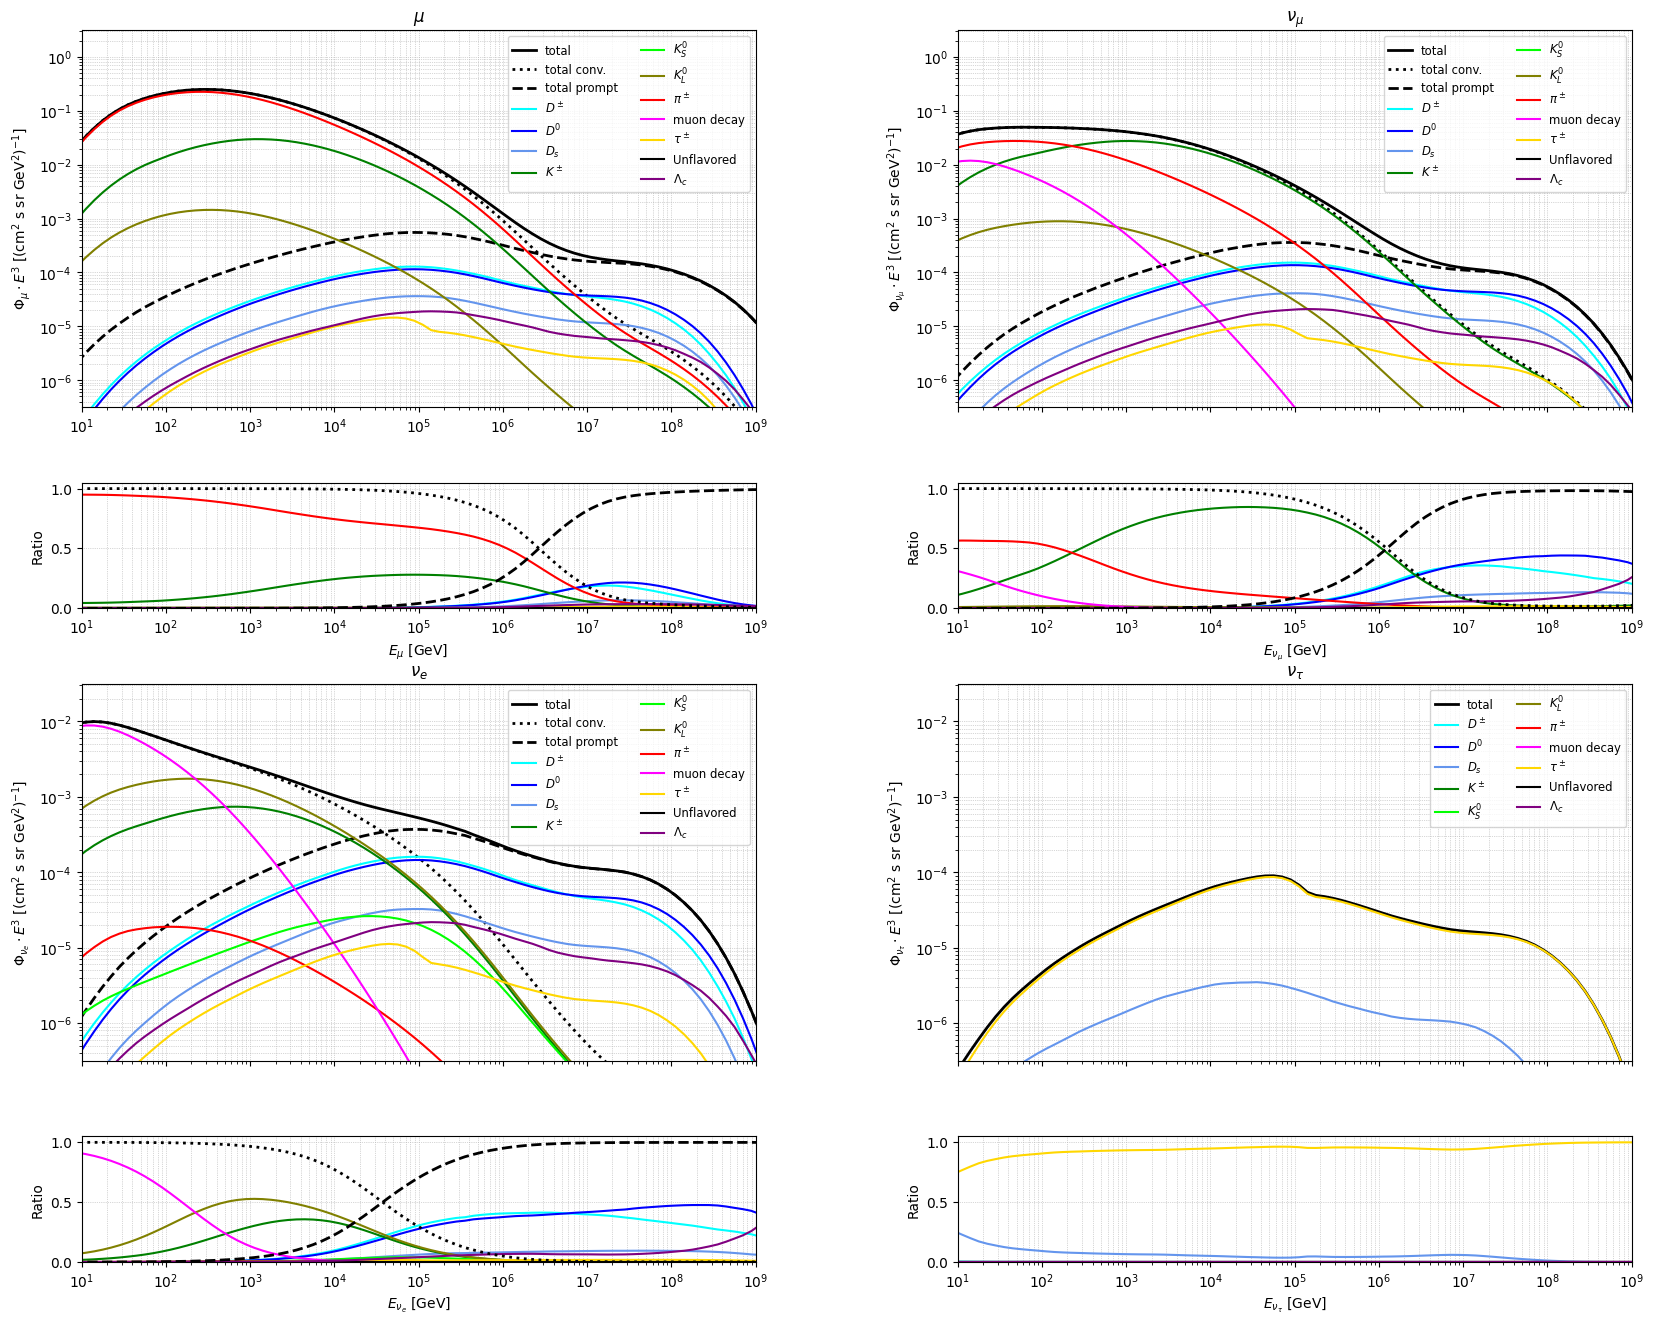

In [22]:
# Optional: nice LaTeX-style labels for source names
label_map = {
    'Dpm': r'$D^\pm$',                                  # D+ and D-
    'D0': r'$D^0$',                                     # D0 and anti-D0
    'Ds': r'$D_s$',                                     # Ds+ and Ds-
    'Kpm': r'$K^\pm$',                                  # K+ and K-
    'K0s': r'$K^0_S$',                                  # K0 short
    'K0L': r'$K^0_L$',                                  # K0 long
    'Pion': r'$\pi^\pm$',                               # pi+ and pi-
    'LambdaC': r'$\Lambda_c$',                          # Lambda_c+ and anti-Lambda_c
    'Unflavoured': r'unflavoured',                      # neutral unflavoured mesons
    'Tau': r'$\tau^\pm$',                               # Tau+ and Tau-
    'Muon': r'muon decay',                              # Muon+ and Muon-
}

# Map each particle to a fixed color
color_map = {
    'Dpm': 'cyan',
    'D0': 'blue',
    'Ds': 'cornflowerblue',
    'Kpm': 'green',
    'K0s': 'lime',
    'K0L': 'olive',
    'Pion': 'red',
    'LambdaC': 'purple',
    'Unflavoured': 'orange',
    'Tau': 'gold',
    'Muon': 'magenta',
}

LABEL_MAP  = label_map
COLOR_MAP  = color_map

fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(4, 2, height_ratios=[3, 1]*2, hspace=0.3, wspace=0.3)

e_grid = mceq_run.e_grid

# ---------- MUONS ----------
ax_mu = fig.add_subplot(gs[0, 0])
ax_mu.set_title(r"$\mu$")
ax_mu.plot(e_grid, mu_total, ls='-', lw=2, color='black', label='total')
ax_mu.plot(e_grid, mu_conv, ls='dotted', lw=2, color='black', label='total conv.')
ax_mu.plot(e_grid, mu_prompt, ls='--', lw=2, color='black', label='total prompt')

for key, flux in mu_obs.items():
    ax_mu.plot(e_grid, flux, ls='-', lw=1.5, color=color_map.get(key, 'black'),
               label=label_map.get(key, key))

ax_mu.set_xscale('log')
ax_mu.set_yscale('log')
ax_mu.set_xlim([10, 1e9])
ax_mu.set_ylim([10**(-6.5), 10**(0.5)])
ax_mu.set_ylabel(r"$\Phi_{{\mu}} \cdot E^{{{}}}$".format(mag) + r" [(cm$^{2}$ s sr GeV$^{2}$)$^{-1}$]")
ax_mu.legend(loc='upper right', fontsize='small', ncol=2, frameon=True)
ax_mu.grid(True, which='both', ls=':', lw=0.5)


# Ratio subplot
ax_mu_ratio = fig.add_subplot(gs[1, 0], sharex=ax_mu)
for key, flux in mu_obs.items():
    ratio = np.divide(flux, mu_total, out=np.zeros_like(flux), where=mu_total > 0)
    ax_mu_ratio.plot(e_grid, ratio, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                     label=label_map.get(key, key))

ax_mu_ratio.plot(e_grid, mu_conv/mu_total, ls='dotted', lw=2, color='black')
ax_mu_ratio.plot(e_grid, mu_prompt/mu_total, ls='--', lw=2, color='black')
ax_mu_ratio.set_xscale('log')
ax_mu_ratio.set_xlabel(r"$E_{\mu}$ [GeV]")
ax_mu_ratio.set_ylabel("Ratio")
ax_mu_ratio.set_ylim([0, 1.05])
ax_mu_ratio.grid(True, which='both', ls=':', lw=0.5)

# ---------- MUON NEUTRINOS ----------
ax_numu = fig.add_subplot(gs[0, 1])
ax_numu.set_title(r"$\nu_{\mu}$")
ax_numu.plot(e_grid, numu_total, ls='-', lw=2, color='black', label='total')

# Optional conv/prompt components
ax_numu.plot(e_grid, numu_conv, ls='dotted', lw=2, color='black', label='total conv.')
ax_numu.plot(e_grid, numu_prompt, ls='--', lw=2, color='black', label='total prompt')

# Plot subcomponents
for key, flux in numu_obs.items():
    ax_numu.plot(e_grid, flux, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                 label=label_map.get(key, key))

ax_numu.set_xscale('log')
ax_numu.set_yscale('log')
ax_numu.set_xlim([10, 1e9])
ax_numu.set_ylim([10**(-6.5), 10**(0.5)])
ax_numu.set_ylabel(r"$\Phi_{{\nu_{{\mu}}}} \cdot E^{{{}}}$".format(mag) + r" [(cm$^{2}$ s sr GeV$^{2}$)$^{-1}$]")
ax_numu.legend(loc='upper right', fontsize='small', ncol=2, frameon=True)
ax_numu.grid(True, which='both', ls=':', lw=0.5)
plt.setp(ax_numu.get_xticklabels(), visible=False)  # hide x-axis ticks for upper plot

# ---------- RATIO: Subcomponents / Total ----------
ax_numu_ratio = fig.add_subplot(gs[1, 1], sharex=ax_numu)

for key, flux in numu_obs.items():
    ratio = np.divide(flux, numu_total, out=np.zeros_like(flux), where=numu_total > 0)
    ax_numu_ratio.plot(e_grid, ratio, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                       label=label_map.get(key, key))

ax_numu_ratio.plot(e_grid, numu_conv/numu_total, ls='dotted', lw=2, color='black')
ax_numu_ratio.plot(e_grid, numu_prompt/numu_total, ls='--', lw=2, color='black')
ax_numu_ratio.set_xscale('log')
ax_numu_ratio.set_xlabel(r"$E_{\nu_{\mu}}$ [GeV]")
ax_numu_ratio.set_ylabel("Ratio")
ax_numu_ratio.set_ylim([0, 1.05])
ax_numu_ratio.grid(True, which='both', ls=':', lw=0.5)

# ---------- ELECTRON NEUTRINOS ----------
ax_nue = fig.add_subplot(gs[2, 0])
ax_nue.set_title(r"$\nu_{e}$")
ax_nue.plot(e_grid, nue_total, ls='-', lw=2, color='black', label='total')

# Optional conv/prompt components
ax_nue.plot(e_grid, nue_conv, ls='dotted', lw=2, color='black', label='total conv.')
ax_nue.plot(e_grid, nue_prompt, ls='--', lw=2, color='black', label='total prompt')

# Plot subcomponent contributions
for key, flux in nue_obs.items():
    ax_nue.plot(e_grid, flux, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                label=label_map.get(key, key))

ax_nue.set_xscale('log')
ax_nue.set_yscale('log')
ax_nue.set_xlim([10, 1e9])
ax_nue.set_ylim([10**(-6.5), 10**(-1.5)])
ax_nue.set_ylabel(r"$\Phi_{{\nu_{{e}}}} \cdot E^{{{}}}$".format(mag) + r" [(cm$^{2}$ s sr GeV$^{2}$)$^{-1}$]")
ax_nue.legend(loc='upper right', fontsize='small', ncol=2, frameon=True)
ax_nue.grid(True, which='both', ls=':', lw=0.5)
plt.setp(ax_nue.get_xticklabels(), visible=False)  # hide x-ticks on upper plot

# ---------- RATIO: Subcomponents / Total ----------
ax_nue_ratio = fig.add_subplot(gs[3, 0], sharex=ax_nue)

for key, flux in nue_obs.items():
    ratio = np.divide(flux, nue_total, out=np.zeros_like(flux), where=nue_total > 0)
    ax_nue_ratio.plot(e_grid, ratio, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                      label=label_map.get(key, key))

ax_nue_ratio.plot(e_grid, nue_conv/nue_total, ls='dotted', lw=2, color='black')
ax_nue_ratio.plot(e_grid, nue_prompt/nue_total, ls='--', lw=2, color='black')
ax_nue_ratio.set_xscale('log')
ax_nue_ratio.set_xlabel(r"$E_{\nu_{e}}$ [GeV]")
ax_nue_ratio.set_ylabel("Ratio")
ax_nue_ratio.set_ylim([0, 1.05])
ax_nue_ratio.grid(True, which='both', ls=':', lw=0.5)

# ---------- TAU NEUTRINOS ----------
ax_nutau = fig.add_subplot(gs[2, 1])
ax_nutau.set_title(r"$\nu_{\tau}$")
ax_nutau.plot(e_grid, nutau_total, ls='-', lw=2, color='black', label='total')

# Plot subcomponent contributions
for key, flux in nutau_obs.items():
    ax_nutau.plot(e_grid, flux, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                  label=label_map.get(key, key))

ax_nutau.set_xscale('log')
ax_nutau.set_yscale('log')
ax_nutau.set_xlim([10, 1e9])
ax_nutau.set_ylim([10**(-6.5), 10**(-1.5)])
ax_nutau.set_ylabel(r"$\Phi_{{\nu_{{\tau}}}} \cdot E^{{{}}}$".format(mag) + r" [(cm$^{2}$ s sr GeV$^{2}$)$^{-1}$]")
ax_nutau.legend(loc='upper right', fontsize='small', ncol=2, frameon=True)
ax_nutau.grid(True, which='both', ls=':', lw=0.5)
plt.setp(ax_nutau.get_xticklabels(), visible=False)  # hide x-ticks on upper plot

# ---------- RATIO: Subcomponents / Total ----------
ax_nutau_ratio = fig.add_subplot(gs[3, 1], sharex=ax_nutau)

for key, flux in nutau_obs.items():
    ratio = np.divide(flux, nutau_total, out=np.zeros_like(flux), where=nutau_total > 0)
    ax_nutau_ratio.plot(e_grid, ratio, ls='-', lw=1.5, color=color_map.get(key, 'black'),
                        label=label_map.get(key, key))

ax_nutau_ratio.set_xscale('log')
ax_nutau_ratio.set_xlabel(r"$E_{\nu_{\tau}}$ [GeV]")
ax_nutau_ratio.set_ylabel("Ratio")
ax_nutau_ratio.set_ylim([0, 1.05])
ax_nutau_ratio.grid(True, which='both', ls=':', lw=0.5)

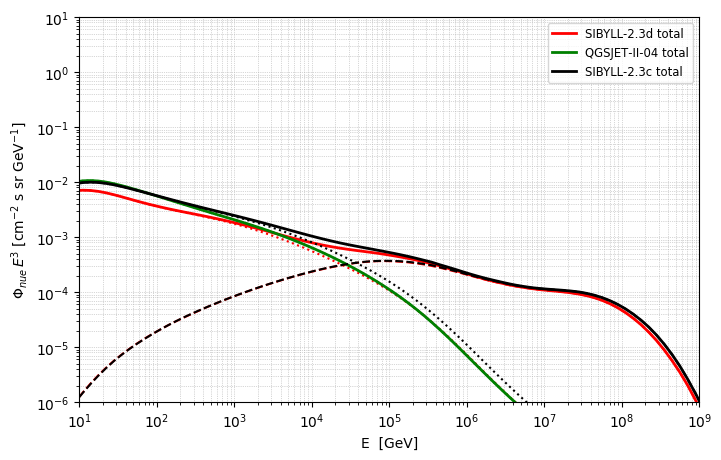

In [ ]:
# CONFIGURATION — adjust to taste
particle       = "nue"        # "mu", "numu", "nue", "nutau"
energy_weight  = 3             # plot Φ·E^3, etc.
run_ids        = {             # map run‑id → short label & color
    2: dict(label="SIBYLL‑2.3d", color="red"),
    3: dict(label="QGSJET‑II‑04", color="green"),
    4: dict(label="SIBYLL‑2.3c", color="black"),
}

#function that loads the data from each file
import gzip, pickle, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def load_angle_average(pkl_file):
    with gzip.open(pkl_file, "rb") as fh:
        data = pickle.load(fh)          # we saved a *single* dict
    return data["primary"], data["parents"], data["zeniths"]


spectra = {}
e_grid = mceq_run.e_grid

for run_id, meta in run_ids.items():
    pkl_path = Path(f"/net/apphome/home/nbenton/angleAvg_{run_id}.pkl.gz")
    primary, _, _ = load_angle_average(pkl_path)

    # grab the shared energy grid once (every pickle has the same)
#    if energy_grid is None:
#        energy_grid = primary["energy"]          # we saved it under this key

    # convenience — zeros with same shape for missing components
    z = np.zeros_like(e_grid)

    total   = primary[ f"{particle}_total" ]
    conv    = primary.get( f"{particle}_conv",   z )
    prompt  = primary.get( f"{particle}_prompt", z )

    #weight  = e_grid ** energy_weight

    spectra[run_id] = dict(
        total   = total,
        conv    = conv,
        prompt  = prompt,
        meta    = meta,                # keep the label / color
    )



fig, ax = plt.subplots(figsize=(8,5))

for run_id, spec in spectra.items():
    lbl   = spec["meta"]["label"]
    col   = spec["meta"]["color"]
    ax.plot(e_grid, spec["total"],  lw=2,   color=col, label=f"{lbl} total")
    ax.plot(e_grid, spec["conv"],   lw=1.5, ls=":",  color=col, alpha=1)
    ax.plot(e_grid, spec["prompt"], lw=1.5, ls="--", color=col, alpha=1)

ax.set_xscale("log");  ax.set_yscale("log")
ax.set_xlim(10, 1e9);  ax.set_ylim(1e-6, 1e1)
ax.set_xlabel("E  [GeV]")
ax.set_ylabel(rf"$\Phi_{{{particle}}}\,E^{energy_weight}$ "
              "[cm$^{-2}$ s sr GeV$^{-1}$]")
ax.legend(fontsize="small")
ax.grid(True, which="both", ls=":", lw=0.5)
plt.show()

In [26]:
#LOAD FROM FILE
def load_angle_average(pkl_file: str):
    """
    Returns primary, parents, zeniths just as produced by average_over_angles.
    """
    import gzip, pickle
    with gzip.open(pkl_file, "rb") as fh:
        data = pickle.load(fh)
    return data["primary"], data["parents"], data["zeniths"]

from pathlib import Path

primary, parents, zeniths = load_angle_average(
    Path("angleAvg_3.pkl.gz")
)

In [29]:
parents["nue"]

{'Dpm': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 'D0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
